# Tutorial 1: Entanglement Forging for estimating the ground state energy of the H<sub>2</sub> molecule

**Entanglement forging** is a method which allows us to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical optimization, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

Furthermore, entanglement forging permits the circuits necessary for the n-qubit simulations to be shallower, relaxing requirements on gate error and connectivity, at the cost of increased quantum and classical runtimes.

In the `Circuit Knitting Toolbox`, entanglement forging is most easily run using the `EntanglementForgingGroundStateSolver` interface, which wraps most of the algorithm within a single function call, `solve`. Steps 1-4 describe the workflow within `solve`. See the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) for more detailed information:

***Estimate the ground state energy of a given system, Ĥ<sub>2n</sub>, with respect to a 2n-qubit wavefunction,Ψ<sub>2n</sub>, using only n qubits***

 1. **Decompose**:
  * Specify the parameterized, n-qubit ansatz circuit, **Ψ<sup>θ</sup><sub>n</sub>**, and select the Schmidt terms over which to optimize.
      * The same circuit will be used for both n-qubit subsystems, U and V
      * Different Schmidt terms may be selected for each subsystem, but the number of expectation values calculated at each loop would increase
  * Decompose **Ψ<sub>2n</sub>** into j, n-qubit ansatze, [Ψ<sub>n<sub>0</sub></sub>, ..., Ψ<sub>n<sub>j</sub></sub>], based on the input ansatz circuit and the selected Schmidt terms
  * Decompose **Ĥ<sub>2n</sub>** into k, n-qubit observables, [H<sub>n<sub>0</sub></sub>, ..., H<sub>n<sub>k</sub></sub>]


 2. **Evaluate**:
  * Apply ansatz circuit parameters, **θ<sub>i</sub>**
  * Calculate expectation values for each basis of the decomposed observable with respect to the selected Schmidt basis and the current ansatz parameters: **[<Ψ<sup>θ<sub>0</sub></sup><sub>0</sub>|H<sub>0</sub>|Ψ<sup>θ<sub>0</sub></sup><sub>0</sub>>, ..., <Ψ<sup>θ<sub>i</sub></sup><sub>k</sub>|H<sub>j</sub>|Ψ<sup>θ<sub>i</sub></sup><sub>k</sub>>]**
  
  
 3. **Reconstruct** 
  * Use the expectation values to reconstruct an estimation of the expectation value for the 2n-qubit system, **<Ψ<sub>2n</sub>|H<sub>2n</sub>|Ψ<sub>2n</sub>>**
  
  
 4. **If energy value has not converged to a minima, update θ<sub>i</sub> to θ<sub>i+1</sub> and continue with Step 2.**

### Instantiate the `ElectronicStructureProblem`

Next, we set up the $\mathrm{H}_2$ molecule, specify the driver and converter, and instantiate an  `ElectronicStructureProblem`, just like is done in the [Qiskit Nature VQE tutorial](https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/03_ground_state_solvers.ipynb).

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.735]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver)

### Prepare the bitstrings and the ansatz

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the "explanatory material" section of the documentation for additional background on the method.) For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the `TwoLocal` circuit from Qiskit.

In [2]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal

ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

Alternatively, if a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

### Set up EntanglementForgingGroundStateSolver
Next, we set up the `EntanglementForgingGroundStateSolver`. It is passed the ansatz, a classical optimizer (COBYLA, in this case), and an initial point.

 * The ansatz field is required.
 * If no optimizer is passed, SPSA with default settings will be used.
 * If the initial_point field is not set, it will be initialized to all 0's.

In [10]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

optimizer = COBYLA(maxiter=100)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    initial_point=[0.0, np.pi / 2],
)

### Calculate the ground state energy

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`.

In [11]:
%%capture

results = solver.solve(problem)

### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


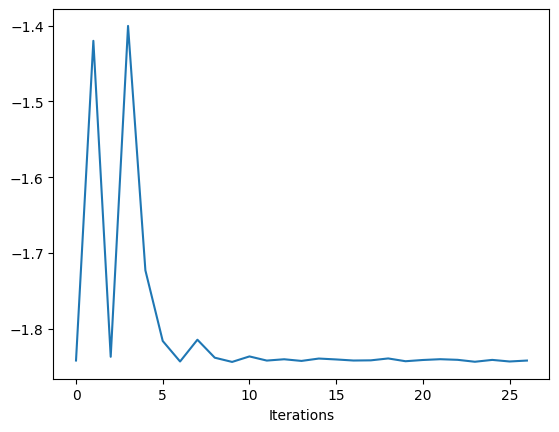

Schmidt Coefficients:


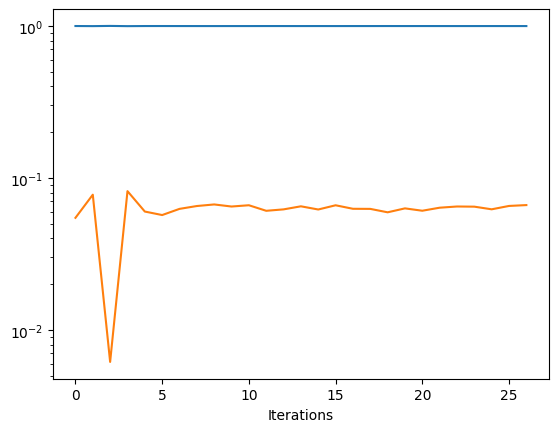

Parameters:


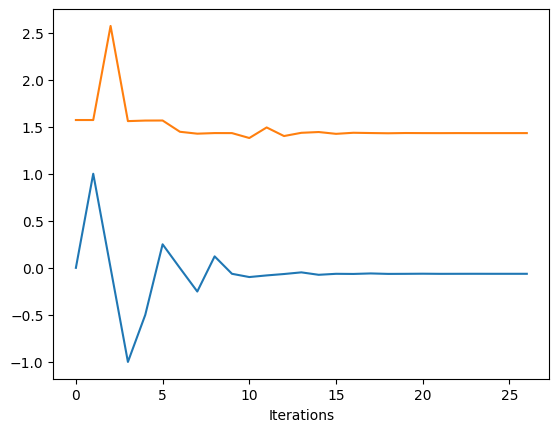

In [12]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [13]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.